In [1]:
import os
import cv2
import glob
import random
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from ultralytics import YOLO


In [2]:
# Define dataset paths (Kaggle environment)
path_masks = "/home/aventior_sant/Downloads/Kaiser_task/skin_infections_using_image_segmentation_or_object_detection/HAM10000_segmentations_lesion/"
path_data = "/home/aventior_sant/Downloads/Kaiser_task/skin_infections_using_image_segmentation_or_object_detection/Skin_dataset/"

print("Data Loaded")


Data Loaded


In [3]:
metadata = pd.read_csv(os.path.join(path_data, "HAM10000_metadata.csv"))
metadata.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
# Combine images from both image folders
img_dirs = [
    os.path.join(path_data, "HAM10000_images_part_1"),
    os.path.join(path_data, "HAM10000_images_part_2")
]

image_dict = {}

for folder in img_dirs:
    for fname in os.listdir(folder):
        img_id = fname.split(".")[0]
        image_dict[img_id] = os.path.join(folder, fname)

dataset_records = []

for mask_file in tqdm(os.listdir(path_masks)):
    if mask_file.endswith(".png"):
        image_id = mask_file.replace("_segmentation.png", "")
        
        dataset_records.append({
            "image_id": image_id,
            "image_path": image_dict.get(image_id),
            "mask_path": os.path.join(path_masks, mask_file),
            "label": metadata.loc[metadata["image_id"] == image_id, "dx"].values[0]
        })

df = pd.DataFrame(dataset_records)
df.head()


100%|███████████████████████████████████| 10015/10015 [00:08<00:00, 1239.91it/s]


,image_id,image_path,mask_path,label
0,ISIC_0031832,/home/aventior_sant/Downloads/Kaiser_task/skin...,/home/aventior_sant/Downloads/Kaiser_task/skin...,nv
1,ISIC_0030727,/home/aventior_sant/Downloads/Kaiser_task/skin...,/home/aventior_sant/Downloads/Kaiser_task/skin...,nv
2,ISIC_0025290,/home/aventior_sant/Downloads/Kaiser_task/skin...,/home/aventior_sant/Downloads/Kaiser_task/skin...,nv
3,ISIC_0031676,/home/aventior_sant/Downloads/Kaiser_task/skin...,/home/aventior_sant/Downloads/Kaiser_task/skin...,nv
4,ISIC_0024664,/home/aventior_sant/Downloads/Kaiser_task/skin...,/home/aventior_sant/Downloads/Kaiser_task/skin...,nv


In [5]:
def mask_to_bbox(mask):
    coords = cv2.findNonZero(mask)
    x, y, w, h = cv2.boundingRect(coords)
    return x, y, w, h

def convert_to_yolo(size, box):
    dw, dh = 1/size[0], 1/size[1]
    x = (box[0] + box[2]/2) * dw
    y = (box[1] + box[3]/2) * dh
    w = box[2] * dw
    h = box[3] * dh
    return x, y, w, h


In [6]:
output_dir = "yolo_dataset"
train_img = f"{output_dir}/train/images"
train_lbl = f"{output_dir}/train/labels"

val_img = f"{output_dir}/val/images"
val_lbl = f"{output_dir}/val/labels"

for folder in [train_img, train_lbl, val_img, val_lbl]:
    os.makedirs(folder, exist_ok=True)


In [7]:
split_ratio = 0.8
ids = df["image_id"].tolist()
np.random.shuffle(ids)
train_ids = set(ids[: int(0.8 * len(ids))])

for idx, row in tqdm(df.iterrows(), total=len(df)):
    img = cv2.imread(row["image_path"])
    mask = cv2.imread(row["mask_path"], cv2.IMREAD_GRAYSCALE)
    
    if img is None or mask is None: continue
    if np.sum(mask) == 0: continue
    
    bbox = mask_to_bbox(mask)
    yolo_format = convert_to_yolo((img.shape[1], img.shape[0]), bbox)
    
    img_dest = train_img if row.image_id in train_ids else val_img
    lbl_dest = train_lbl if row.image_id in train_ids else val_lbl

    shutil.copy(row.image_path, os.path.join(img_dest, f"{row.image_id}.jpg"))
    
    with open(os.path.join(lbl_dest, f"{row.image_id}.txt"), "w") as f:
        f.write(f"0 {' '.join(map(str, yolo_format))}\n")


100%|████████████████████████████████████| 10015/10015 [01:37<00:00, 102.77it/s]


In [8]:
yaml = """train: yolo_dataset/train/images
val: yolo_dataset/val/images
nc: 1
names: ["skin_lesion"]
"""

with open("yolo_dataset/data.yaml", "w") as f:
    f.write(yaml)

print("YOLO training config ready.")


YOLO training config ready.


In [9]:
import os

# Automatically detect your absolute folder path
ROOT_DIR = os.path.abspath("yolo_dataset")

train_path = os.path.join(ROOT_DIR, "train", "images")
val_path = os.path.join(ROOT_DIR, "val", "images")

yaml_content = f"""
train: {train_path}
val: {val_path}

nc: 1
names: ["skin_lesion"]
"""

with open("yolo_dataset/data.yaml", "w") as f:
    f.write(yaml_content)

print("✔ YAML updated successfully!")
print(yaml_content)


✔ YAML updated successfully!

train: /home/aventior_sant/Downloads/Kaiser_task/skin_infections_using_image_segmentation_or_object_detection/yolo_dataset/train/images
val: /home/aventior_sant/Downloads/Kaiser_task/skin_infections_using_image_segmentation_or_object_detection/yolo_dataset/val/images

nc: 1
names: ["skin_lesion"]



In [10]:
# model = YOLO("yolov8s.pt")

# results = model.train(
#     data="yolo_dataset/data.yaml",
#     epochs=30,
#     imgsz=640,
#     batch=32
# )


In [11]:
# model.val()


In [12]:
# test_images = glob.glob(os.path.join(path_data, "HAM10000_images_part_2", "*.jpg"))[:12]

# preds = model.predict(source=test_images, save=True, conf=0.55)
# print("Prediction Complete ✓")


In [13]:
import os
import numpy as np
import pandas as pd
import cv2
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model


In [14]:
# Define dataset paths (Kaggle environment)
path_masks = "/home/aventior_sant/Downloads/Kaiser_task/skin_infections_using_image_segmentation_or_object_detection/HAM10000_segmentations_lesion/"
path_data = "/home/aventior_sant/Downloads/Kaiser_task/skin_infections_using_image_segmentation_or_object_detection/Skin_dataset/"

print("Data Loaded")


Data Loaded


In [15]:
metadata = pd.read_csv(os.path.join(path_data, "HAM10000_metadata.csv"))
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [16]:
# Normalize image dictionary
image_dict = {}

for folder in img_dirs:
    for f in os.listdir(folder):
        fname = f.strip().lower()
        if fname.endswith((".jpg", ".jpeg", ".png")):
            img_id = os.path.splitext(fname)[0]
            image_dict[img_id] = os.path.join(folder, f)

print("Total unique images found:", len(image_dict))





Total unique images found: 10015


In [17]:
dataset = []

for mask_file in os.listdir(path_masks):
    fname = mask_file.strip().lower()
    
    if fname.endswith(".png"):
        # strip "_segmentation"
        img_id = fname.replace("_segmentation.png", "").strip()

        if img_id in image_dict:
            dataset.append([image_dict[img_id], os.path.join(path_masks, mask_file)])


In [18]:
df = pd.DataFrame(dataset, columns=["image", "mask"])
print("Total matched image-mask pairs:", len(df))
df.head()


Total matched image-mask pairs: 10015


,image,mask
0,/home/aventior_sant/Downloads/Kaiser_task/skin...,/home/aventior_sant/Downloads/Kaiser_task/skin...
1,/home/aventior_sant/Downloads/Kaiser_task/skin...,/home/aventior_sant/Downloads/Kaiser_task/skin...
2,/home/aventior_sant/Downloads/Kaiser_task/skin...,/home/aventior_sant/Downloads/Kaiser_task/skin...
3,/home/aventior_sant/Downloads/Kaiser_task/skin...,/home/aventior_sant/Downloads/Kaiser_task/skin...
4,/home/aventior_sant/Downloads/Kaiser_task/skin...,/home/aventior_sant/Downloads/Kaiser_task/skin...


In [19]:
df = df[df["image"].apply(os.path.exists)]
df = df[df["mask"].apply(os.path.exists)]

df.reset_index(drop=True, inplace=True)

print("After validation:", len(df))


After validation: 10015


In [23]:
IMG_SIZE = 128

def load_image(path):
    if not isinstance(path, str) or not os.path.exists(path):
        return None
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img / 255.0

def load_mask(path):
    if not isinstance(path, str) or not os.path.exists(path):
        return None
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = mask.astype(np.float32) / 255.0
    return np.expand_dims(mask, axis=-1)


In [24]:
images, masks = [], []

for i, row in tqdm(df.iterrows(), total=len(df)):
    img = load_image(row["image"])
    mask = load_mask(row["mask"])
    
    if img is None or mask is None:
        continue
    
    images.append(img)
    masks.append(mask)

images = np.array(images)
masks = np.array(masks)

print("Final usable samples:", len(images))


100%|████████████████████████████████████| 10015/10015 [01:18<00:00, 127.46it/s]


Final usable samples: 10015


In [25]:
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [26]:
def conv_block(x, filters):
    x = Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = Conv2D(filters, 3, padding='same', activation='relu')(x)
    return x

def build_unet():
    inputs = Input((IMG_SIZE, IMG_SIZE, 3))

    c1 = conv_block(inputs, 16)
    p1 = MaxPooling2D()(c1)

    c2 = conv_block(p1, 32)
    p2 = MaxPooling2D()(c2)

    c3 = conv_block(p2, 64)

    u1 = UpSampling2D()(c3)
    u1 = Concatenate()([u1, c2])
    c4 = conv_block(u1, 32)

    u2 = UpSampling2D()(c4)
    u2 = Concatenate()([u2, c1])
    c5 = conv_block(u2, 16)

    outputs = Conv2D(1, 1, activation="sigmoid")(c5)

    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

model = build_unet()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 96)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │     27,680 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 48)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │      6,928 │ concatenate_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d_8[0][0]  

 Total params: 118,273 (462.00 KB)

 Trainable params: 118,273 (462.00 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     epochs=20,
#     batch_size=16
# )


## when Train Model kernal dead may be GPU issue

### Create a Smaller Training Subset

In [61]:
# Reduce dataset size for CPU training
df_small = df.sample(2000, random_state=42).reset_index(drop=True)

len(df_small)


2000

In [62]:
df_small

,image,mask
0,/home/aventior_sant/Downloads/Kaiser_task/skin...,/home/aventior_sant/Downloads/Kaiser_task/skin...
1,/home/aventior_sant/Downloads/Kaiser_task/skin...,/home/aventior_sant/Downloads/Kaiser_task/skin...
2,/home/aventior_sant/Downloads/Kaiser_task/skin...,/home/aventior_sant/Downloads/Kaiser_task/skin...
3,/home/aventior_sant/Downloads/Kaiser_task/skin...,/home/aventior_sant/Downloads/Kaiser_task/skin...
4,/home/aventior_sant/Downloads/Kaiser_task/skin...,/home/aventior_sant/Downloads/Kaiser_task/skin...
...,...,...
1995,/home/aventior_sant/Downloads/Kaiser_task/skin...,/home/aventior_sant/Downloads/Kaiser_task/skin...
1996,/home/aventior_sant/Downloads/Kaiser_task/skin...,/home/aventior_sant/Downloads/Kaiser_task/skin...
1997,/home/aventior_sant/Downloads/Kaiser_task/skin...,/home/aventior_sant/Downloads/Kaiser_task/skin...
1998,/home/aventior_sant/Downloads/Kaiser_task/skin...,/home/aventior_sant/Downloads/Kaiser_task/skin...


In [63]:
df_small = df_small[df_small["image"].apply(os.path.exists)]
df_small = df_small[df_small["mask"].apply(os.path.exists)]

df_small.reset_index(drop=True, inplace=True)

print("After validation:", len(df_small))


After validation: 2000


In [64]:
print(df_small.dtypes)
print(df_small.head())



image    object
mask     object
dtype: object
                                               image  \
0  /home/aventior_sant/Downloads/Kaiser_task/skin...   
1  /home/aventior_sant/Downloads/Kaiser_task/skin...   
2  /home/aventior_sant/Downloads/Kaiser_task/skin...   
3  /home/aventior_sant/Downloads/Kaiser_task/skin...   
4  /home/aventior_sant/Downloads/Kaiser_task/skin...   

                                                mask  
0  /home/aventior_sant/Downloads/Kaiser_task/skin...  
1  /home/aventior_sant/Downloads/Kaiser_task/skin...  
2  /home/aventior_sant/Downloads/Kaiser_task/skin...  
3  /home/aventior_sant/Downloads/Kaiser_task/skin...  
4  /home/aventior_sant/Downloads/Kaiser_task/skin...  


In [65]:
print(repr(df_small.iloc[0].image))
print(repr(df_small.iloc[0].mask))


'/home/aventior_sant/Downloads/Kaiser_task/skin_infections_using_image_segmentation_or_object_detection/Skin_dataset/HAM10000_images_part_1/ISIC_0027084.jpg'
<bound method NDFrame.mask of image    /home/aventior_sant/Downloads/Kaiser_task/skin...
mask     /home/aventior_sant/Downloads/Kaiser_task/skin...
Name: 0, dtype: object>


In [66]:
df_small = df_small.rename(columns={"mask": "mask_path"})
print(df_small.head())


                                               image  \
0  /home/aventior_sant/Downloads/Kaiser_task/skin...   
1  /home/aventior_sant/Downloads/Kaiser_task/skin...   
2  /home/aventior_sant/Downloads/Kaiser_task/skin...   
3  /home/aventior_sant/Downloads/Kaiser_task/skin...   
4  /home/aventior_sant/Downloads/Kaiser_task/skin...   

                                           mask_path  
0  /home/aventior_sant/Downloads/Kaiser_task/skin...  
1  /home/aventior_sant/Downloads/Kaiser_task/skin...  
2  /home/aventior_sant/Downloads/Kaiser_task/skin...  
3  /home/aventior_sant/Downloads/Kaiser_task/skin...  
4  /home/aventior_sant/Downloads/Kaiser_task/skin...  


In [67]:
print(df_small.iloc[0].mask_path)
print(os.path.exists(df_small.iloc[0].mask_path))


/home/aventior_sant/Downloads/Kaiser_task/skin_infections_using_image_segmentation_or_object_detection/HAM10000_segmentations_lesion/ISIC_0027084_segmentation.png
True


In [68]:
images, masks = [], []

for i, row in tqdm(df_small.iterrows(), total=len(df_small)):
    img = load_image(row.image)
    mask = load_mask(row.mask_path)

    if img is None or mask is None:
        continue
        
    images.append(img)
    masks.append(mask)

images = np.array(images)
masks = np.array(masks)

print("Final usable samples:", len(images))


100%|██████████████████████████████████████| 2000/2000 [00:16<00:00, 119.18it/s]


Final usable samples: 2000


In [69]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    images, masks, test_size=0.2, random_state=42
)


In [70]:
def build_mini_unet():

    inputs = Input((IMG_SIZE, IMG_SIZE, 3))

    # Encoder
    c1 = Conv2D(8, 3, activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(16, 3, activation='relu', padding='same')(p1)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(32, 3, activation='relu', padding='same')(p2)

    # Decoder
    u1 = UpSampling2D()(c3)
    u1 = Concatenate()([u1, c2])
    c4 = Conv2D(16, 3, activation='relu', padding='same')(u1)

    u2 = UpSampling2D()(c4)
    u2 = Concatenate()([u2, c1])
    c5 = Conv2D(8, 3, activation='relu', padding='same')(u2)

    outputs = Conv2D(1, 1, activation='sigmoid')(c5)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_mini_unet()
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 128, 128,  │        224 │ input_layer_2[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64, 8) │          0 │ conv2d_17[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 64, 64,    │      1,168 │ max_pooling2d_4[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 32, 32,    │      4,640 │ max_pooling2d_5[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 64, 64,    │          0 │ conv2d_19[0][0]   │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 64, 64,    │          0 │ up_sampling2d_4[… │
│ (Concatenate)       │ 48)               │            │ conv2d_18[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │      6,928 │ concatenate_4[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_5     │ (None, 128, 128,  │          0 │ conv2d_20[0][0]   │
│ (UpSampling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 128, 128,  │          0 │ up_sampling2d_5[… │
│ (Concatenate)       │ 24)               │            │ conv2d_17[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │      1,736 │ concatenate_5[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │          9 │ conv2d_21[0][0]   │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,705 (57.44 KB)

 Trainable params: 14,705 (57.44 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=8,     # small to avoid RAM crash
    epochs=8,         # short training
    verbose=1
)


Epoch 1/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.8099 - loss: 0.4148 - val_accuracy: 0.8624 - val_loss: 0.3240
Epoch 2/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8666 - loss: 0.3232 - val_accuracy: 0.8720 - val_loss: 0.3099
Epoch 3/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.8752 - loss: 0.3075 - val_accuracy: 0.8598 - val_loss: 0.3471
Epoch 4/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.8842 - loss: 0.2891 - val_accuracy: 0.8926 - val_loss: 0.2796
Epoch 5/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.8859 - loss: 0.2858 - val_accuracy: 0.8988 - val_loss: 0.2691
Epoch 6/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.8917 - loss: 0.2718 - val_accuracy: 0.8939 - val_loss: 0.2647
Epoch 7/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.8938 - loss: 0.2702 - val_accuracy: 0.8969 - val_loss: 0.2580
Epoch 8/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8987 - loss: 0.2553 - val_accura

### Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


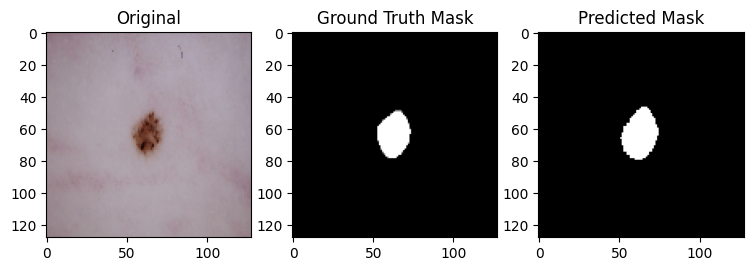

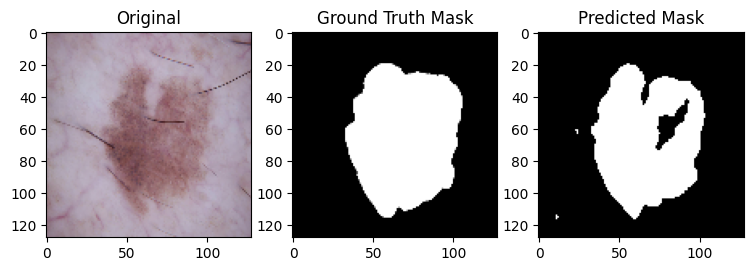

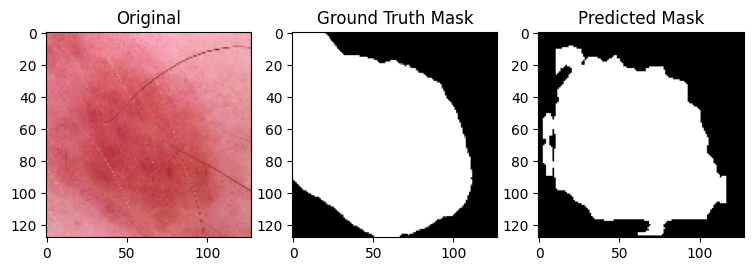

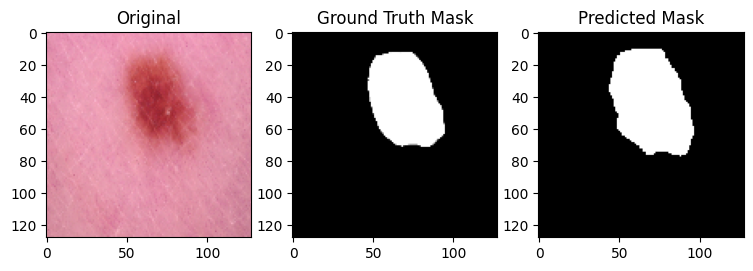

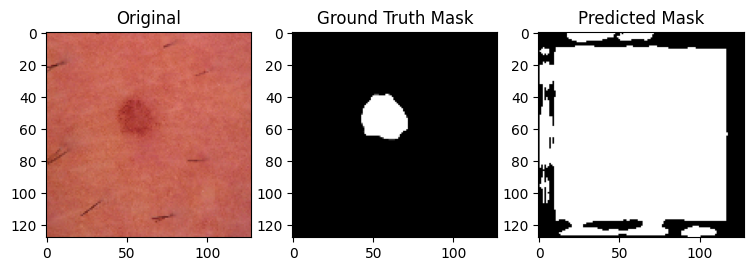

In [72]:
preds = (model.predict(X_val[:10]) > 0.5).astype(np.uint8)

for i in range(5):
    plt.figure(figsize=(9,3))

    plt.subplot(1,3,1)
    plt.imshow(X_val[i])
    plt.title("Original")

    plt.subplot(1,3,2)
    plt.imshow(y_val[i].squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")

    plt.subplot(1,3,3)
    plt.imshow(preds[i].squeeze(), cmap='gray')
    plt.title("Predicted Mask")

    plt.show()


In [73]:
preds = model.predict(X_val[:10])   # run prediction
preds = (preds > 0.5).astype(np.uint8)  # threshold for mask output


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


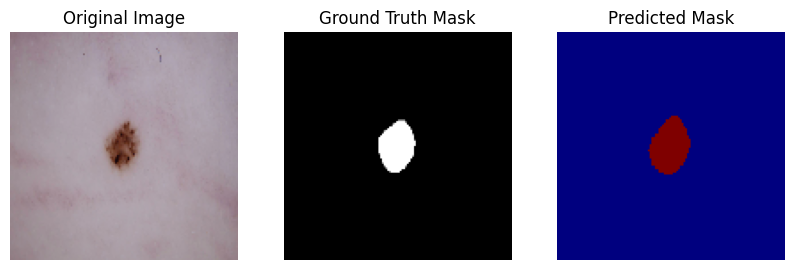

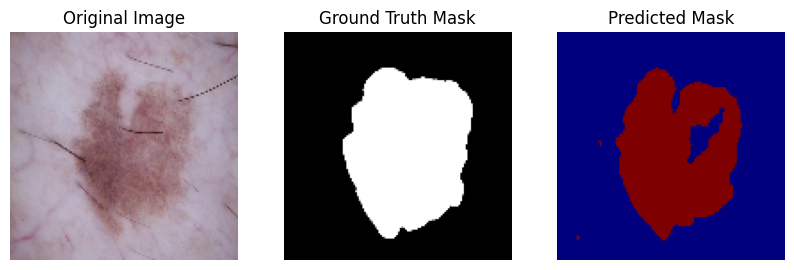

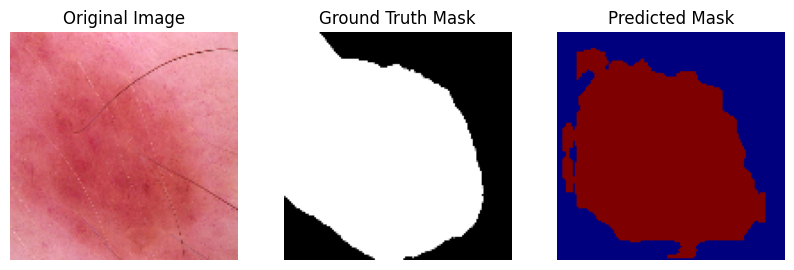

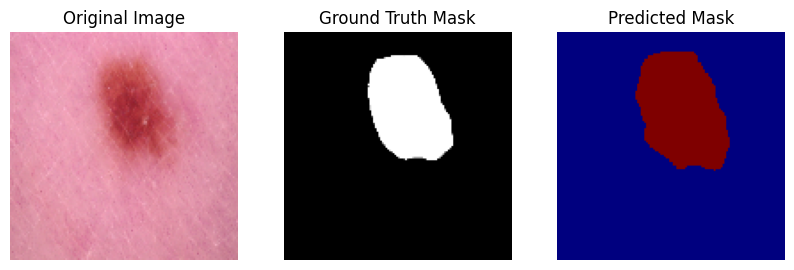

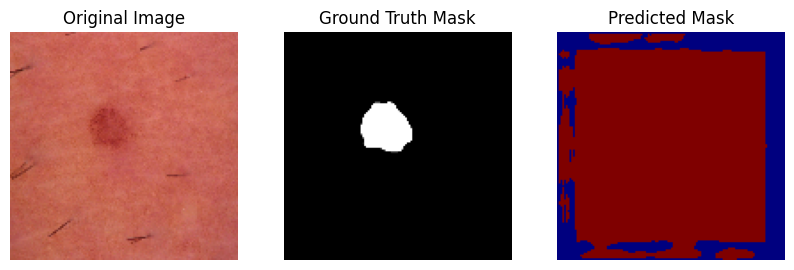

In [74]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.figure(figsize=(10,3))

    # Original
    plt.subplot(1,3,1)
    plt.imshow(X_val[i])
    plt.title("Original Image")
    plt.axis("off")

    # Ground truth
    plt.subplot(1,3,2)
    plt.imshow(y_val[i].squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

    # Predicted
    plt.subplot(1,3,3)
    plt.imshow(preds[i].squeeze(), cmap='jet')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()


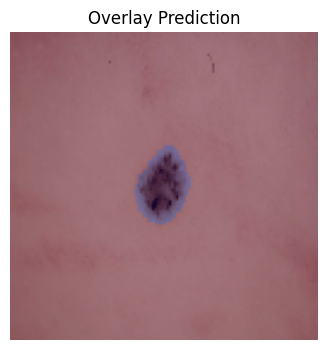

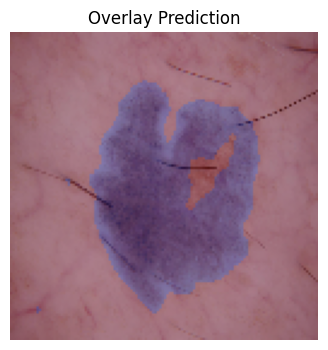

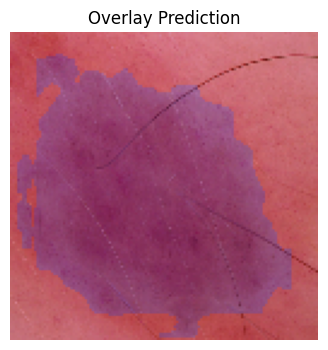

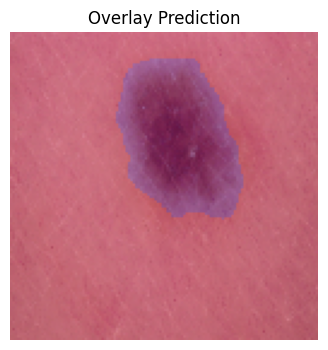

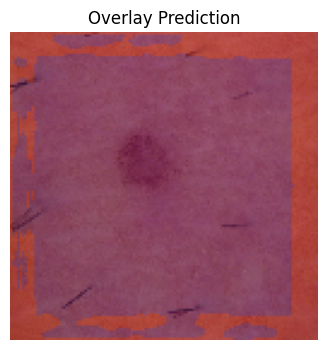

In [75]:
import cv2

for i in range(5):
    img = (X_val[i] * 255).astype(np.uint8)
    mask_pred = preds[i].squeeze() * 255

    colored_mask = cv2.applyColorMap(mask_pred.astype(np.uint8), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img, 0.7, colored_mask, 0.3, 0)

    plt.figure(figsize=(6,4))
    plt.imshow(overlay)
    plt.title("Overlay Prediction")
    plt.axis("off")
    plt.show()


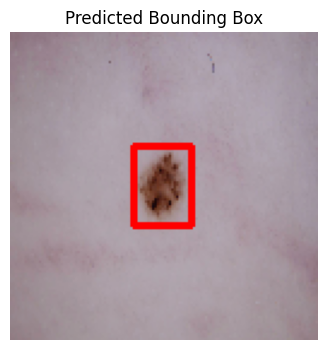

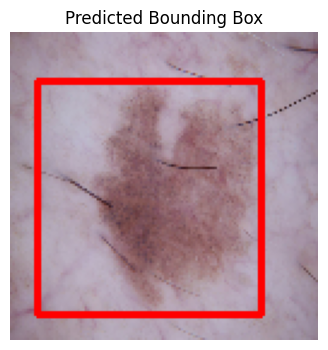

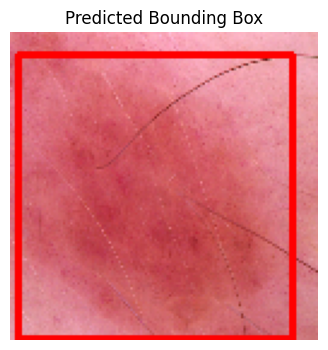

In [76]:
def get_bbox(mask):
    mask = (mask.squeeze() * 255).astype(np.uint8)
    coords = cv2.findNonZero(mask)
    if coords is None:
        return None
    x, y, w, h = cv2.boundingRect(coords)
    return x, y, w, h

for i in range(3):
    img = (X_val[i] * 255).astype(np.uint8).copy()
    bbox = get_bbox(preds[i])

    if bbox:
        x, y, w, h = bbox
        cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 2)

    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.title("Predicted Bounding Box")
    plt.axis("off")
    plt.show()


In [79]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ---- 1) Select one sample image and mask ----
idx = 0  # pick any sample
selected_image = X_val[idx]                # normalized image from validation set
original = (selected_image * 255).astype(np.uint8)

# ---- 2) Expand dims → model expects (1, H, W, 3) ----
img_array = np.expand_dims(selected_image, axis=0)


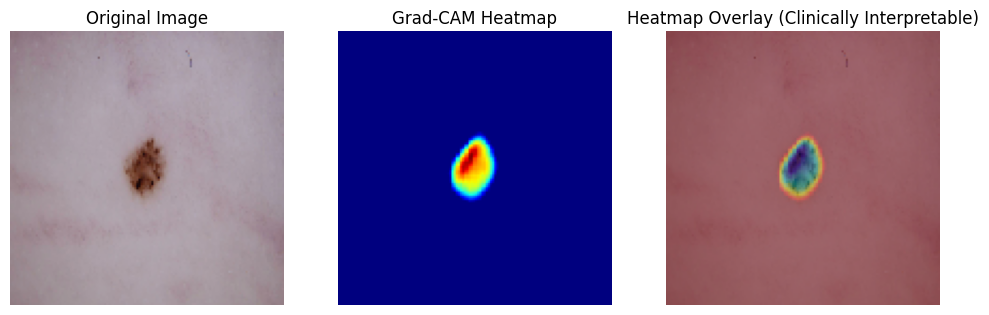

In [83]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ---- Select validation sample ----
idx = 0
selected_image = X_val[idx]               # already normalized (0-1)
original = (selected_image * 255).astype(np.uint8)
img_array = np.expand_dims(selected_image, axis=0)  # make batch size 1


def grad_cam(model, img_array, layer_name):
    
    # Fix #1 - Correct grad model input structure
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, preds = grad_model(img_array)
        loss = tf.reduce_mean(preds)  # segmentation output is continuous mask

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output[0]

    # dot product between feature maps & gradient importance
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-10  # normalize safely

    return heatmap  # Fix #2: return array directly


# ---- Compute heatmap using correct conv layer ----
heatmap = grad_cam(model, img_array, "conv2d_21")

# ---- Resize to match image ----
heatmap = cv2.resize(heatmap, (original.shape[1], original.shape[0]))


# ---- Create overlay ----
heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(original, 0.6, heatmap_color, 0.4, 0)


# ---- Display ----
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(original)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(heatmap, cmap="jet")
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Heatmap Overlay (Clinically Interpretable)")
plt.axis("off")

plt.show()
